# Regularizers as memory

The greatest challenge in modern AI research is the limiting returns computational work. 
While the greatest advances can only be afforded by large technology firms, even they 
cannot afford to push results further. A clear plateau has developed. 
Insufficient computational efficiency motivates a return to theory, begs a question: 
_where is waste most significant?_ 

The advent of catestrophic forgetting shows raw, non-compressed information must be continually re-applied 
if it is not to be forgotten. If important information could be preserved--even partially--we would expect 
more efficient computation. In short, _this work targets the realization of memory_.

Regularized likelihood equations have a Lagrangian form, so implicitly describe geometric constraints on estimates.
For example, here's an estimate constrained to an L2-sphere in $\Theta$-space.

$$ \hat \theta_{L_2} = \text{arg max}_{\theta \in \Theta} n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) - \lambda \| \theta \|_2^2 $$

In this work, we'll generalize the regularizer $\| \cdot \|_2^2$ to support alternative geometries, 
in attempting to construct numerically convenient memory approximations. 
Particulary, we'll seek to approximate the following equation.
Note that it introduces quadratic geometric constraints on the estimate. 

$$ \hat \theta = \text{arg max}_{\theta \in \Theta} n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) - \frac{\lambda}{2} (\theta - \theta_0)^T \mathcal{I}_{\theta_0} (\theta - \theta_0) $$

## RL-reweighted (RLR) estimates 

This first estimate is designed to improve efficiency of sampling in reinforcement learning (RL) by 
up-weighting more-important observations. We'll use this estimate:

$$ \hat \theta_{RLR} = \hat \theta_{n_1+n_2} = \text{arg max}_\theta \left( \sum_{i=1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \right)^{-1} \left( \sum_{i=n_1+1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \log f_X(X_i; \theta) - \sum_{i=1}^{n_1} \frac{\lambda}{2} (\theta - \hat \theta_{n_1+n_2-1})^T H_i (\theta - \hat \theta_{n_1+n_2-1}) \right) $$

where 
- $n_1$ is the number of priviously observed sameples, 
- $n_2$ is the number of newly observed samples, 
- $\hat r_i$ is the estimated reward for observation $i$, 
- $b > 0$ is a bias term,  
- $H_i = \| \hat r_i \|^{2b}_2 \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right) \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right)^T$ is a Hessian approximation, and
- $\hat \theta_0$ is an initial estimate guess, commonly required in optimization routines. 

Define $ M:= \sum_{i=1}^{n_1}(\theta - \theta_{n_1+n_2-1})^TH_i(\theta - \theta_{n_1+n_2-1})$, which we'll refer to as the "memory term". 
The key heuristic is that $M$, a quadratic regularizer, approximates large-sample likelihoods under maximization. 
This insight can be seen through a Taylor approximation near true $\theta$, designated $\theta_T$.

$\hat \theta_{MLE} = \text{arg max}_\theta n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + n^{-1}\sum_i (\theta - \theta_T)^T \nabla_\theta \log f_X(X_i; \theta_T) + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + 0 + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

This work basically tests the quality of our $M \approx \sum_i (\theta - \theta_T)^T (\nabla_\theta)^2 \log f_X(X_i; \theta_T)(\theta - \theta_T) $ heuristic.
If true, then we should see that the quadratic regularizer, $M$, affects memory through geometric constraints on the estimator.

Later, we'll experiment with recency bias and rank reductions for $M$.

Notice that $\hat \theta_{RLR}$ is asymptotically equivalent to a redistributed sampling, 
with more observations when they are more important. 
Hence, the essence of this computational efficiency strategy is to 
- add frequency bias to important observations, 
- and preserve their information via geometric estimator constraints.

## $M$ and almost-stationary processes

$M$ is an asymptotic result, so only applies when observations are sufficiently many and produced by a stationary or i.i.d process.
While most applied asymptotic theory assumes $\theta_T$ is static, it could also be possible to work with a $\theta_{T_n}$ on a continuous path in $\Theta$ over $n$.
Let us define an _almost-stationary process_ $X_n$ as satisfying the following.

$$ \forall \tau \in \mathbb{R}, \left(t_1, t_2, \ldots, t_m\right) \in \mathbb{R}_{\geq 0}^m, \mathbb{P}\left[ X_{t_{1+\tau}}, X_{t_{2+\tau}}, \ldots, X_{t_{m+\tau}} ; \theta_{t_1+\tau} \right] \text{is continuous in } \tau$$

The question of whether $\theta_{T_n}$ moves "too quickly" is dependent on an given process. 
If, for $n$ large, $M$ still approximates $\sum_i (\theta - \theta_{T_n})^T (\nabla_\theta^2 \log f_X(X_i; \theta_{T_n}))(\theta - \theta_{T_n})$, 
then we'll say $\theta_{T_n}$ is "sufficiently slow". Here are some examples relating to **transfer learning**.
- If we withheld digits 1 & 2 from MNIST for the first 10000 observations, then started including them afterward, 
we should expect $\theta_{T_n}$ to move too quickly. 
- As reinforcement learning (RL) agent explores its world, it's sampling process indeed deforms, albeit slowly. 
This context should have good opportunities for sufficiently slow changes in $\theta_{T_n}$. 
So, our experiments will focus on RL applications.

Developing transfer learning mechanisms for RL is particularly valuable, 
since it is frequently imagined to be a path to artificial general intelligence (AGI).

Side node: almost-stationary process theory clearly needs development. 
My experience has taught me to test the value of theoretical hypotheses before developing them, 
since theoretical development is far more expensive than computational experimentation.
I am confident in this hypothesis, because my previous theoretical developments are very similar. 
Any new proofs would not be very novel, and would be mere adaptations of prior work. 

## Experiment 1: Cartpole

We start with a _very_ simple example, proving-out concepts.

In [1]:
## Define model 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random 

INPUT_DIM = 4
N_ACTIONS = 2
MAX_SAMPLE = 5000
DISCOUNT = .95 
EPS = 1e-5
EXPLORE_PROBABILITY_FUNC = lambda idx: 0.999**idx 
BATCH_SIZE = 100 
LEARNING_RATE = 0.001 
GRAD_CLIP = 10000.0 
LBFGS = False 

class Model(nn.Module): 
    def __init__(self, 
            input_dim=INPUT_DIM, 
            n_actions=N_ACTIONS, 
            discount = DISCOUNT, 
            max_sample=MAX_SAMPLE, 
            eps=EPS): 
        super(Model, self).__init__() 
        ## store config 
        self.input_dim = input_dim 
        self.n_actions = n_actions 
        self.discount = discount 
        self.max_sample = max_sample 
        self.eps = eps 
        ## init feed forward net 
        self.fc1 = nn.Linear(input_dim, 40) 
        self.fc1_bn = nn.BatchNorm1d(40) 
        self.fc2 = nn.Linear(40, 40) 
        self.fc2_bn = nn.BatchNorm1d(40) 
        self.fc3 = nn.Linear(40, n_actions) 
        ## init data structures 
        self.observations = [] 
        if LBFGS: 
            self.optimizer = optim.LBFGS(self.parameters(), history_size=50) ## RAM req = O(history_size * model_dim) 
        else: 
            ## LBFGS was giving nan parameters 
            self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE) 
            pass 
        pass 

    def forward(self, x): 
        x = self.fc1(x)
        x = self.fc1_bn(x) 
        x = torch.tanh(x) 
        x = self.fc2(x) 
        x = self.fc2_bn(x)  
        x = torch.tanh(x) 
        x = self.fc3(x) 
        return x 
    
    def get_action(self, env_state): 
        env_state = torch.tensor(env_state).float() 
        env_state = env_state.reshape([1, -1]) 
        predicted_reward_per_action_idx = self.forward(env_state) 
        return int(predicted_reward_per_action_idx.argmax()) 
    
    def store_observation(self, observation): 
        if len(observation) > self.max_sample: 
            observation = observation[1:] 
        self.observations.append(observation) 
        pass 
    
    def clear_observations(self): 
        self.observations = [] 
        pass 
    
    def __sample(self, sample_max=None): 
        ## random sample 
        obs = self.observations 
        if sample_max is not None: 
            if sample_max < len(self.observations): 
                obs = random.sample(self.observations, sample_max) 
        ## unpack samples 
        samples = [ (torch.tensor(env_state).float(), \
                torch.tensor(reward).float(), \
                torch.tensor(done).int(), \
                torch.tensor(prev_env_state).float(), \
                torch.tensor(action).int()) for \
                (env_state, reward, done, info, prev_env_state, action) in obs] 
        ## build matrices 
        env_state = torch.stack([obs[0] for obs in samples], dim=0) ## inserts dim 0 
        observed_rewards = torch.stack([obs[1] for obs in samples], dim=0) 
        done = torch.stack([obs[2] for obs in samples], dim=0) 
        prev_env_state = torch.stack([obs[3] for obs in samples], dim=0) 
        action = torch.stack([obs[4] for obs in samples], dim=0).reshape([-1, 1]).type(torch.int64) 
        ## calculate target 
        self.eval() 
        predicted_rewards = self.forward(env_state) 
        predicted_rewards = torch.max(predicted_rewards, dim=1, keepdim=True).values.reshape([-1]) 
        target = observed_rewards + (1 - done) * self.discount * predicted_rewards 
        target = target.reshape([-1, 1]).detach() 
        ## calculate prediction  
        self.train() 
        self.zero_grad() 
        predicted_rewards = self.forward(prev_env_state) 
        prediction = predicted_rewards.gather(1, action) 
        return prediction, target 
    
    def get_parameter_vector(self): 
        return nn.utils.parameters_to_vector(self.parameters()) 
    
    def optimize(self, max_iter=None, batch_size=None): 
        iter_n = 0 
        n_dels = 30 
        dels = [None]*n_dels 
        continue_iterating = True 
        halt_method = None 
        loss_f = None 
        mean_reward = None 
        while continue_iterating: 
            prev_theta = self.get_parameter_vector() 
            predicted, target = self.__sample(batch_size) 
            mean_reward = predicted.mean() 
            loss = F.mse_loss(predicted, target) 
            loss_f = float(loss) 
            loss.backward() 
            if not LBFGS: 
                ## lbfgs really doesn't like this 
                nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP) 
            ## lbfgs must re-evaluate target, hence lambda 
            if LBFGS:
                self.optimizer.step(lambda: float(F.mse_loss(predicted, target))) 
            else:
                self.optimizer.step() 
                pass 
            updated_theta = self.get_parameter_vector() 
            ## decide to continue iterating or not 
            if max_iter is not None: 
                if iter_n > max_iter: 
                    ## halt: iters have hit limit 
                    continue_iterating = False 
                    halt_method = 'max-iter' 
            if iter_n >= n_dels: 
                ## test convergence with chebyshev ineq 
                dels = dels[1:] + [(updated_theta - prev_theta).abs().sum()] 
                sigma = torch.tensor(dels).square().mean().sqrt() 
                if (sigma/self.eps)**2 < .95: 
                    ## halt: convergance 
                    continue_iterating = False 
                    halt_method = 'cauchy-convergence' 
            else: 
                ## collect data for variance estimate 
                dels[iter_n] = (updated_theta - prev_theta).abs().sum() 
                pass 
            iter_n += 1 
            pass 
        return loss_f, halt_method, mean_reward  

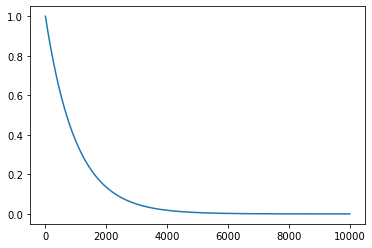

In [2]:
## Define experiment 
import gym 
from tqdm import tqdm 
import numpy as np 
import matplotlib.pyplot as plt 

model = Model() 

env = gym.make('CartPole-v1') 
env_state = env.reset() 
last_start = 0 
last_survival = 0 
n_restarts = 0 
total_reward = 0 
survivals = [] 
total_iters = 10000 

plt.plot([EXPLORE_PROBABILITY_FUNC(idx) for idx in range(total_iters)])
plt.show()

In [3]:
## run experiment 
iters = tqdm(range(total_iters), disable=False) 
for iter_idx in iters: 
  prev_env_state = env_state 
  if EXPLORE_PROBABILITY_FUNC(iter_idx) < np.random.uniform(): 
    ## explore 
    action = env.action_space.sample() 
  else: 
    ## exploit 
    model.eval() 
    action = model.get_action(env_state) 
    pass 
  env_state, reward, done, info = env.step(action) 
  if done:
    total_reward = -1 
    reward = -10
  else: 
    total_reward += reward 
    pass 
  observation = env_state, reward, done, info, prev_env_state, action 
  model.store_observation(observation) 

  if iter_idx > 30 and iter_idx % 1 == 0: 
    #loss, halt_method, mean_reward = model.optimize(max_iter=100, batch_size=BATCH_SIZE) 
    loss, halt_method, mean_reward = model.optimize(max_iter=10, batch_size=600) 
    loss = float(loss) 
    mean_reward = float(mean_reward) 
    param_nan = model.get_parameter_vector().isnan().sum() 
    iters.set_description(f'n_restarts: {n_restarts}, last_survival: {last_survival}, '+\
        f'loss: {round(loss,4)}, halt: {halt_method}, mean_reward: {round(mean_reward,2)}, action: {action}')#+\
        #f'param_nan: {param_nan}, last action: {action}') 
    pass 

  if done: 
    env_state = env.reset() 
    last_survival = iter_idx - last_start 
    survivals.append(last_survival) 
    last_start = iter_idx 
    n_restarts += 1 
    pass 
  pass 
env.close() 

n_restarts: 418, last_survival: 16, loss: 2.1318, halt: max-iter, mean_reward: 18.93, action: 0: 100%|██████████| 10000/10000 [49:21<00:00,  3.38it/s] 


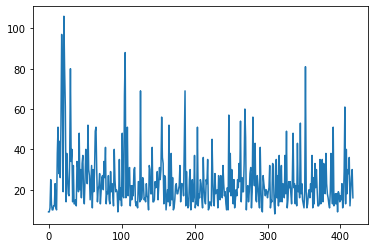

In [4]:
import matplotlib.pyplot as plt
plt.plot(survivals)
plt.show()

In [5]:
for idx, s in enumerate(survivals): 
    print(f'{s} ' , end='') 
    if (idx+1) % 40 == 0: 
        print('') 

9 9 11 25 13 10 10 12 12 23 11 10 38 51 28 44 26 52 97 74 19 106 80 61 14 38 27 18 17 37 80 34 40 14 32 13 13 15 12 34 
31 19 48 20 30 16 33 37 18 13 25 40 34 23 52 30 27 15 23 32 11 30 19 29 49 51 30 14 20 22 28 13 19 26 27 20 34 26 41 13 
19 18 27 15 13 29 19 23 18 12 40 25 19 20 19 9 14 35 15 21 12 48 17 16 67 88 16 20 51 17 30 31 12 22 15 22 17 30 31 14 
12 14 11 24 24 14 69 15 16 26 23 15 16 14 23 17 16 10 32 30 18 18 41 14 14 15 24 21 22 29 15 22 31 25 30 56 36 33 13 27 
26 10 15 20 14 52 12 13 38 15 26 10 11 15 22 23 18 18 20 22 32 14 23 23 22 17 43 69 12 29 17 11 12 25 30 10 19 25 14 17 
37 11 14 13 51 12 18 16 25 23 16 11 36 21 15 13 25 23 35 10 11 14 13 12 45 26 14 12 28 18 19 20 11 27 23 15 27 24 16 32 
23 17 19 13 10 21 10 57 19 38 17 30 18 13 25 11 15 20 17 25 21 33 24 54 14 26 19 19 33 60 46 10 20 22 14 19 28 31 11 19 
56 31 22 43 15 14 27 22 16 11 41 21 10 9 27 23 20 17 20 19 16 19 21 32 11 15 14 33 32 14 8 18 35 16 27 12 37 14 22 32 
14 23 19 16 37 18 49 11 15 24 21 24 

In [6]:
import gym
env = gym.make("CartPole-v1")
observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
env.close()

print(observation)
print(reward)
print(done)
print(info)
print(action)

[ 0.00753649  0.21527015 -0.03573164 -0.29776198]
1.0
False
{}
1
